In [43]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

In [44]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Input,Flatten,Reshape,AveragePooling2D,Dropout,LayerNormalization, ReLU,concatenate,Cropping2D, BatchNormalization
from keras.datasets import mnist
import tensorflow as tf

import keras
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint


In [45]:
image_path = '../dados/CAPTCHA-10k/teste'
def generate_df(image_path):
  label_path = '../dados/CAPTCHA-10k/labels10k'

  jpg_files = [f for f in os.listdir(image_path) if f.endswith('.jpg')]
  jpg_files.sort()
  data = []

  for jpg_file in jpg_files:
      txt_file = os.path.splitext(jpg_file)[0] + '.txt'
      txt_file_path = os.path.join(label_path, txt_file)

      if os.path.exists(txt_file_path):
          with open(txt_file_path, 'r') as file:
              txt_content = file.read().strip()

          data.append({'jpg_file': jpg_file, 'txt_content': txt_content})
  return pd.DataFrame(data)

df = generate_df(image_path)
df.head()

,jpg_file,txt_content
0,009001.jpg,JW4CZF
1,009002.jpg,H27LCM
2,009003.jpg,1EF8W0
3,009004.jpg,HZ1HQE
4,009005.jpg,97CZ9Z


In [46]:
df['txt_content'].str.len().value_counts()

txt_content
6    999
7      1
Name: count, dtype: int64

In [47]:
vocab = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', 'A', 'B',
       'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O',
       'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '*']
np.array(vocab)

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', 'A', 'B',
       'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O',
       'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '*'],
      dtype='<U1')

In [48]:
def preprocess(img):
  kernel  = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
  img     = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
  _, img  = cv2.threshold(img, 90, 255, cv2.THRESH_BINARY)
  return img

In [49]:
def generate_X_Y(image_path):
  df = generate_df(image_path)
  X = [preprocess(cv2.imread(os.path.join(image_path, x),cv2.IMREAD_GRAYSCALE)) for x in df["jpg_file"]]
  X = np.array(X)
  X = np.expand_dims(X, axis=-1)

  X = X.astype('float32') / 255.

  
  return X,df['txt_content']

X_teste,labels_teste = generate_X_Y('../dados/CAPTCHA-10k/teste')

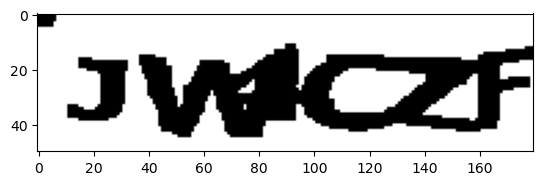

In [50]:
plt.imshow(X_teste[0], cmap='gray')

In [51]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def psnr(y_true, y_pred):
    max_pixel = 1.0
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)

In [52]:
autoencoder = tf.keras.models.load_model('model_BCE_aug_best_unet.tf',custom_objects={"rmse": rmse,"psnr":psnr})
classifier  = tf.keras.models.load_model('classifier_aug_best.tf')

In [53]:
X_teste_ae = autoencoder.predict(X_teste)

32/32 [==============================] - 1s 23ms/step


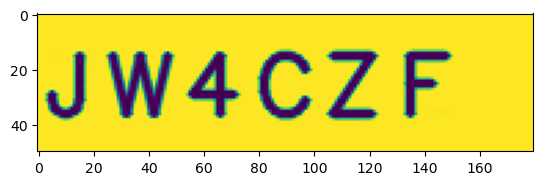

In [54]:
plt.imshow(X_teste_ae[0])

In [55]:
bins = np.arange(0,180,180//7)

In [56]:
from sklearn.preprocessing import OneHotEncoder

def get_x_y_classification(X_pred, labels):
    # Adjust labels if their length is not equal to 7
    labels = labels.apply(lambda x: x + '*' if len(x) != 7 else x)

    # Define bins
    num_parts = 7
    img_width = 180
    bins = np.arange(0,180,180//7)

    # Initialize lists to hold the split images and one-hot encoded labels
    x = []
    y = []

    # One-hot encoder for labels
    encoder = OneHotEncoder()

    # Fit the encoder on the labels (unique characters)
    encoder.fit(np.array(list(vocab)).reshape(-1, 1))

    # Process each image and corresponding label
    for img, label in zip(X_pred, labels):
        # Split the image into 7 parts
        for i in range(num_parts):
            start, end = bins[i], bins[i + 1]
            part_img = img[:, start:end,:]
            x.append(part_img)

            char = label[i]
            one_hot = encoder.transform([[char]])[0]
            y.append(one_hot.toarray())

    # Convert lists to numpy arrays
    x = np.array(x)
    y = np.array(y)
    y = np.squeeze(y, axis=1)
    return x, y

X_teste_class,Y_teste_class = get_x_y_classification(X_teste_ae,labels_teste)

In [57]:
Y_teste_pred = model.predict(X_teste_class)

219/219 [==============================] - 1s 2ms/step


In [58]:
from sklearn.metrics import accuracy_score,classification_report

# Convert one-hot encoded labels to class indices for true labels
Y_val_class_indices = np.argmax(Y_teste_pred, axis=-1)

# Convert predictions to class indices
Y_val_pred_class_indices = np.argmax(Y_teste_class, axis=-1)

# Compute accuracy
accuracy = accuracy_score(Y_val_class_indices, Y_val_pred_class_indices)
print(f'Classification Accuracy: {accuracy}')

Classification Accuracy: 0.9714285714285714


In [59]:
report = classification_report(Y_val_class_indices, Y_val_pred_class_indices, output_dict=True, zero_division=0)
for label, metrics in report.items():
    if label.isdecimal():
        print(f'Class {vocab[int(label)]}:')
        print(f"  Precision: {metrics['precision']:.2f}")
        print(f"  Recall: {metrics['recall']:.2f}")
        print(f"  F1-score: {metrics['f1-score']:.2f}")
        print(f"  Support: {metrics['support']:.2f}\n")
    else:
        print(label,metrics)

Class 0:
  Precision: 1.00
  Recall: 1.00
  F1-score: 1.00
  Support: 1000.00

Class 1:
  Precision: 0.97
  Recall: 0.86
  F1-score: 0.91
  Support: 200.00

Class 2:
  Precision: 0.91
  Recall: 0.97
  F1-score: 0.94
  Support: 159.00

Class 3:
  Precision: 0.99
  Recall: 1.00
  F1-score: 1.00
  Support: 161.00

Class 4:
  Precision: 0.96
  Recall: 0.99
  F1-score: 0.98
  Support: 159.00

Class 5:
  Precision: 0.99
  Recall: 0.99
  F1-score: 0.99
  Support: 160.00

Class 6:
  Precision: 0.98
  Recall: 0.96
  F1-score: 0.97
  Support: 171.00

Class 7:
  Precision: 0.98
  Recall: 0.98
  F1-score: 0.98
  Support: 161.00

Class 8:
  Precision: 0.94
  Recall: 0.99
  F1-score: 0.96
  Support: 149.00

Class 9:
  Precision: 0.96
  Recall: 0.94
  F1-score: 0.95
  Support: 159.00

Class ?:
  Precision: 0.97
  Recall: 0.97
  F1-score: 0.97
  Support: 172.00

Class A:
  Precision: 0.00
  Recall: 0.00
  F1-score: 0.00
  Support: 12.00

Class B:
  Precision: 0.99
  Recall: 1.00
  F1-score: 1.00
  Sup

In [60]:
import cv2
def draw_red_box_cv2(image, start_x, end_x, height=50):
    # Create a copy of the Simage
    image_copy = image.copy()
    
    # Define the rectangle color (BGR format for OpenCV)
    color = (0, 0, 255)  # Red color in BGR
    thickness = 2  # Thickness of the rectangle
    
    # Draw the rectangle
    top_left = (start_x, 0)
    bottom_right = (end_x, height)
    cv2.rectangle(image_copy, top_left, bottom_right, color, thickness)
    
    return image_copy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of misclassified instances: 200
Number of misclassified images: 183


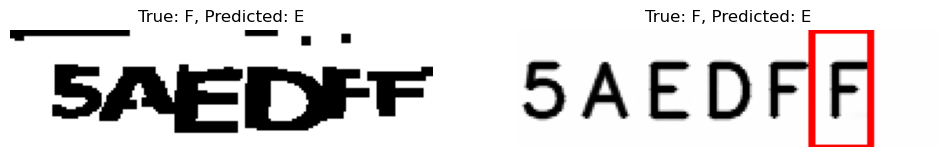

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


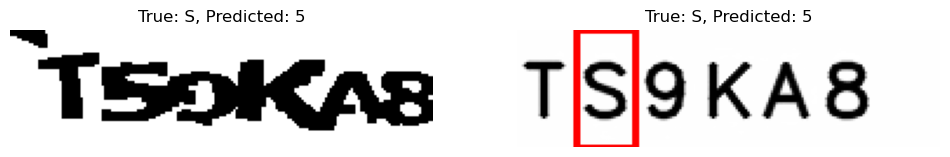

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


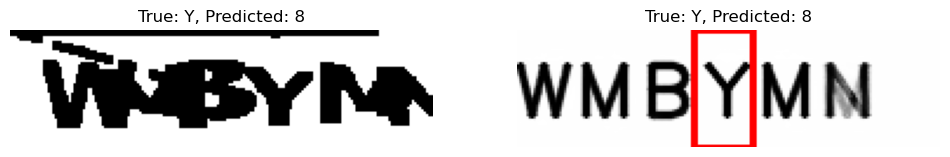

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


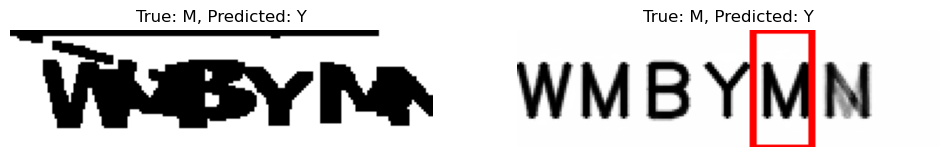

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


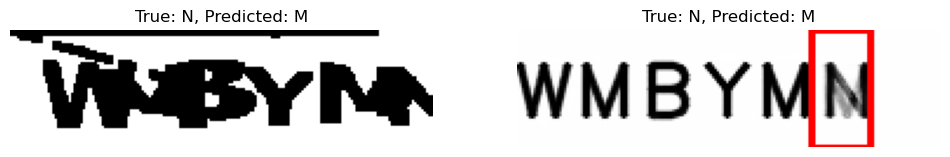

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


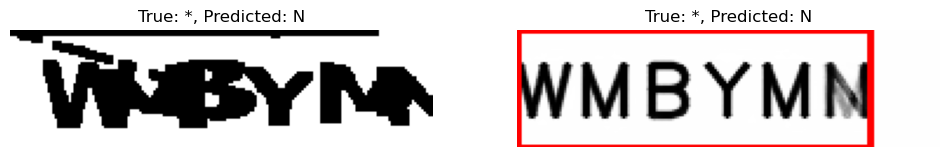

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


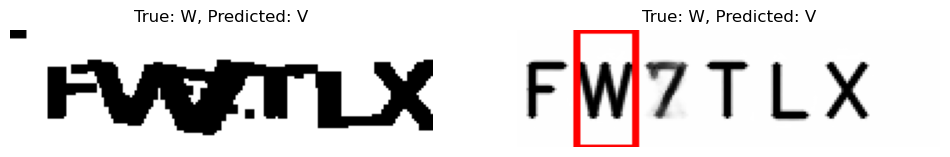

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


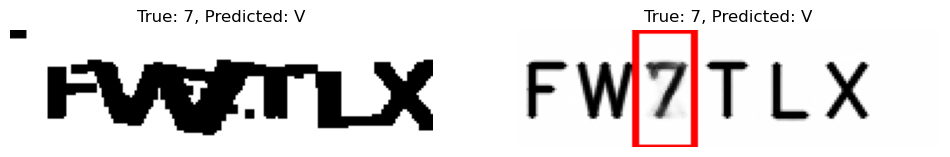

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


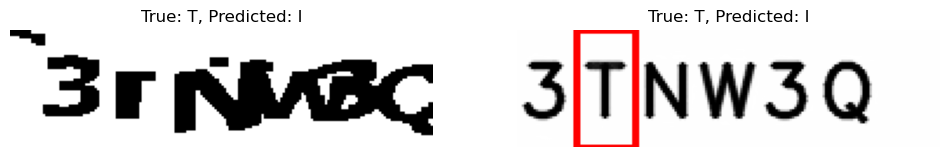

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


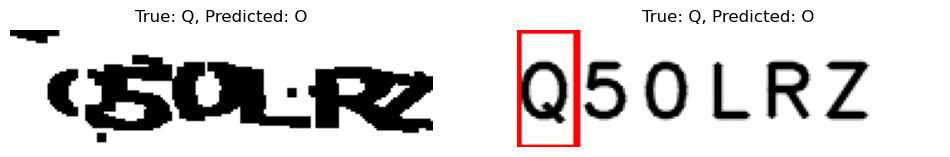

In [61]:
misclassified_indices = np.where(Y_val_class_indices != Y_val_pred_class_indices)[0]
print(f"Number of misclassified instances: {len(misclassified_indices)}")
print(f"Number of misclassified images: {len(np.unique(misclassified_indices//7))}")

# Print the first few misclassified instances
for i in misclassified_indices[10:20]:  # Adjust the number as needed
    start_x = bins[(i) % 7]
    end_x = bins[(i + 1) % 7]
    height = 50  # Fixed height of the red box

    original_image = X_teste[i // 7]  # Original image
    predicted_image = X_teste_ae[i // 7].squeeze()  # Remove the single channel dimension if it exists
    
    # Convert grayscale images to RGB
    original_image_rgb = cv2.cvtColor(original_image.squeeze(), cv2.COLOR_GRAY2RGB)
    predicted_image_rgb = cv2.cvtColor(predicted_image, cv2.COLOR_GRAY2RGB)
    
    # Draw the red box on the predicted image
    predicted_image_with_box = draw_red_box_cv2(predicted_image_rgb, start_x, end_x, height)

    plt.figure(figsize=(12, 6))  # Adjust the size as needed
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_image_rgb, cv2.COLOR_BGR2RGB))
    plt.title(f"True: {vocab[Y_val_class_indices[i]-1]}, Predicted: {vocab[Y_val_pred_class_indices[i]-1]}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(predicted_image_with_box, cv2.COLOR_BGR2RGB))
    plt.title(f"True: {vocab[Y_val_class_indices[i]-1]}, Predicted: {vocab[Y_val_pred_class_indices[i]-1]}")
    plt.axis('off')
    plt.show()

In [62]:
unique_miss = len(np.unique(misclassified_indices//7))
unique_miss /=X_teste.shape[0]
1 - unique_miss

0.817